# Number of births by months in USSR/Russia

https://www.kaggle.com/datasets/puff1n/number-of-births-by-months-in-ussrrussia

The file contains 3 columns: year (1970 - 2018, excluding 2003 and 2004), month and number of people born. There is seasonality in the dynamics of fertility, but why did the peaks in fertility move over the past decades and how can this be verified correctly?

## План работ

* Проверка данных (пропуски, типы)
* Описательная статистика основного датасета
* Добавить признак государства
* Добавить месяц/год результатом которого является показатель рождаемости
* Эксперименты с визуализацией датасета, выводы
* Визуализация месяцов повышенной фертильности
* Найти данные по рождаемости с 2019 по 2023 г
* Найти данный по общей численности
* Подобрать относительный показатель рождаемости / смернтости за период
* Визуализация дополненных данных

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('years-months-births.csv', sep='\t')

### 1. Проверка основного датасета

In [5]:
df.head(5)

,year,month,births_gks
0,1956,1,294461
1,1956,2,241272
2,1956,3,252344
3,1956,4,239466
4,1956,5,233260


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   year        732 non-null    int64
 1   month       732 non-null    int64
 2   births_gks  732 non-null    int64
dtypes: int64(3)
memory usage: 17.3 KB


### 2. Описание основного датасета

In [9]:
df.describe()

,year,month,births_gks
count,732.000000,732.000000,732.000000
mean,1986.459016,6.500000,164416.024590
std,18.241043,3.454413,38142.438731
min,1956.000000,1.000000,87968.000000
25%,1971.000000,3.750000,137370.750000
50%,1986.000000,6.500000,163265.000000
75%,2001.000000,9.250000,189541.250000
max,2018.000000,12.000000,294554.000000


In [11]:
# Добавим признак принадлежности к государству в зависимости от года
df['country']=df.year.apply(lambda x: 'CCCР' if x <= 1991 else 'РФ')
df.head()

,year,month,births_gks,country
0,1956,1,294461,CCCР
1,1956,2,241272,CCCР
2,1956,3,252344,CCCР
3,1956,4,239466,CCCР
4,1956,5,233260,CCCР


In [13]:
df[df.births_gks == df.births_gks.min()]
# Минимальное число родившихся - ноябрь 1999 г. (в составе РФ)

,year,month,births_gks,country
526,1999,11,87968,РФ


In [15]:
df[df.births_gks == df.births_gks.max()]
# Наибольшее количество новорожденных - январь 1958 г. (в составе СССР)

,year,month,births_gks,country
24,1958,1,294554,CCCР


In [17]:
# Статистика сгруппированная по годам
df_by_year = df.groupby(by='year')['births_gks'].agg(['min', 'max', 'median', 'mean', 'sum'])
df_by_year

,min,max,median,mean,sum
year,,,,,
1956,197167,294461,224861.5,230776.666667,2769320
1957,200926,290178,232632.5,235966.500000,2831598
1958,210507,294554,233516.0,234934.000000,2819208
1959,207215,289736,231296.5,233019.000000,2796228
1960,196704,280955,228335.0,231862.750000,2782353
...,...,...,...,...,...
2014,145492,180725,160449.0,161890.250000,1942683
2015,143425,182130,159193.0,161714.833333,1940578
2016,146607,173955,156073.0,157394.000000,1888728


In [19]:
# Статистика сгруппированная по признаку государства
df_by_country = df.groupby(by='country')['births_gks'].agg(['min', 'max', 'median', 'mean', 'sum'])
df_by_country

,min,max,median,mean,sum
country,,,,,
CCCР,130570,294554,184852.0,187739.895833,81103635
РФ,87968,182130,128835.5,130829.650000,39248895


In [21]:
df_by_year[df_by_year['sum'] == df_by_year['sum'].max()]
# Наибольшее количество новорожденных зафиксировано в 1957 г. - 2.831 млн чел (СССР)

,min,max,median,mean,sum
year,,,,,
1957,200926,290178,232632.5,235966.5,2831598


In [23]:
df_by_year[df_by_year['sum'] == df_by_year['sum'].min()]
# Минимальное количество новорожденных зафиксировано в 1999 г. - 1.2 млн чел (РФ)

,min,max,median,mean,sum
year,,,,,
1999,87968,109603,103096.5,101221.0,1214652


### 3. Поиск месяца/года повлиявшего на показатель рождаемости

In [25]:
def conception_period(month, year):
    '''
    Определяем месяц и год, повлиявшие на 
    отчетный уровень рождаемости
    '''
    if (month - 9) < 0:
        conc_year = year - 1
        conc_month = 12 + (month - 9)
    elif (month - 9) == 0:
        conc_year = year - 1
        conc_month = 12
    else:
        conc_month = month - 9
        conc_year = year
    return [conc_month, conc_year]

In [27]:
# Добавляем столбцы для выведения результатов функции conception_period()

df['conc_month'] = df.apply(lambda x: conception_period(x.month, x.year)[0], axis=1)
df['conc_year'] = df.apply(lambda x: conception_period(x.month, x.year)[1], axis=1)

In [29]:
df

,year,month,births_gks,country,conc_month,conc_year
0,1956,1,294461,CCCР,4,1955
1,1956,2,241272,CCCР,5,1955
2,1956,3,252344,CCCР,6,1955
3,1956,4,239466,CCCР,7,1955
4,1956,5,233260,CCCР,8,1955
...,...,...,...,...,...,...
727,2018,8,148258,РФ,11,2017
728,2018,9,136661,РФ,12,2017
729,2018,10,137500,РФ,1,2018
730,2018,11,125731,РФ,2,2018


### 4. Визуализация датасета

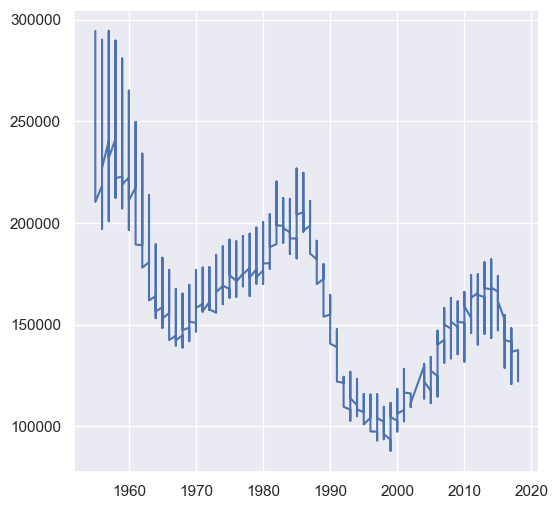

In [96]:
#plt.plot(df.year, df.births_gks)
plt.plot(df.conc_year, df.births_gks);

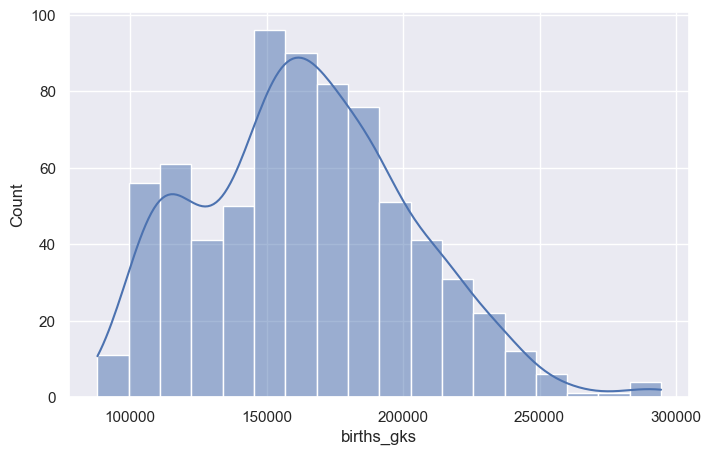

In [102]:
sns.set_theme(rc={'figure.figsize':(8,5)})
sns.histplot(df['births_gks'], kde = True);

In [35]:
ussr_df = df[df.country == 'CCCР']
ussr_df

,year,month,births_gks,country,conc_month,conc_year
0,1956,1,294461,CCCР,4,1955
1,1956,2,241272,CCCР,5,1955
2,1956,3,252344,CCCР,6,1955
3,1956,4,239466,CCCР,7,1955
4,1956,5,233260,CCCР,8,1955
...,...,...,...,...,...,...
427,1991,8,147864,CCCР,11,1990
428,1991,9,140660,CCCР,12,1990
429,1991,10,138984,CCCР,1,1991
430,1991,11,131698,CCCР,2,1991


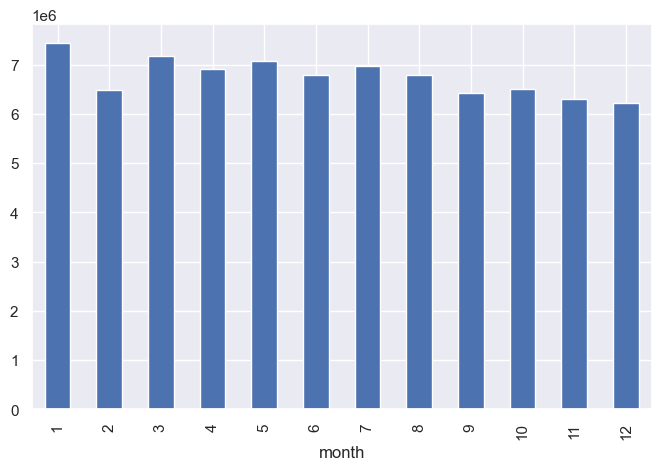

In [104]:
ussr_df.groupby('month')['births_gks'].sum().plot(kind='bar');

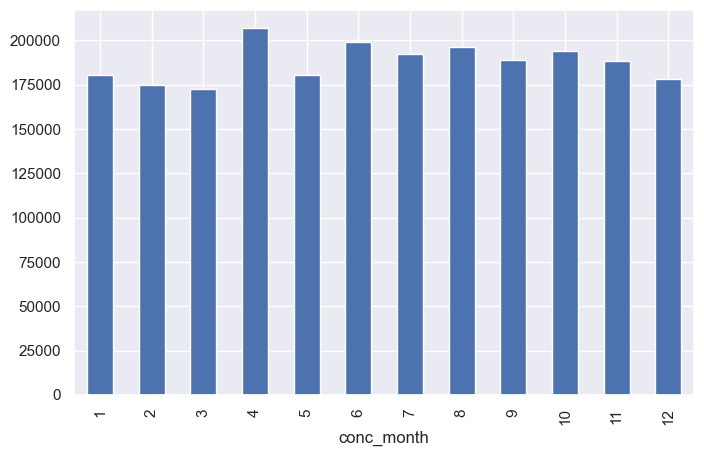

In [106]:
ussr_df.groupby('conc_month')['births_gks'].mean().plot(kind='bar');

In [118]:
# Сводная таблица рождаемости месяц/год в период СССР
birth_USSR_pivot_table = df[df.country == 'CCCР'].pivot_table(values='births_gks', index = 'month', columns = 'year')
birth_USSR_pivot_table

year,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,...,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991
month,,,,,,,,,,,,,,,,,,,,,
1,294461.0,290178.0,294554.0,289736.0,280955.0,265111.0,249768.0,234133.0,213661.0,189538.0,...,194908.0,210062.0,204260.0,208092.0,200238.0,216884.0,200185.0,191280.0,179784.0,164631.0
2,241272.0,229414.0,232751.0,230352.0,238607.0,217249.0,204527.0,194746.0,184027.0,163187.0,...,177834.0,190237.0,190281.0,184870.0,182614.0,196589.0,191401.0,173891.0,161184.0,148590.0
3,252344.0,258313.0,251086.0,252283.0,258328.0,242617.0,226143.0,215102.0,198818.0,183332.0,...,195418.0,216907.0,208247.0,202725.0,209093.0,219430.0,208124.0,190259.0,175827.0,163715.0
4,239466.0,241065.0,238452.0,239995.0,238177.0,228813.0,216624.0,203642.0,186166.0,173506.0,...,189673.0,209251.0,201315.0,197602.0,213401.0,217377.0,200298.0,179947.0,168284.0,156595.0
5,233260.0,236346.0,239615.0,234549.0,237652.0,229030.0,217543.0,202722.0,184834.0,173397.0,...,199187.0,219821.0,209917.0,206490.0,215664.0,224720.0,210061.0,189713.0,175922.0,160731.0
6,217554.0,213227.0,212919.0,219438.0,218852.0,211090.0,202436.0,190353.0,171076.0,162538.0,...,201273.0,214740.0,207552.0,204458.0,215393.0,219937.0,208069.0,189563.0,174354.0,154894.0
7,226033.0,230459.0,210507.0,232241.0,229043.0,218625.0,210143.0,195514.0,175174.0,164817.0,...,204349.0,220421.0,212308.0,211893.0,226812.0,218535.0,210901.0,189551.0,174833.0,155657.0
8,223690.0,234806.0,219301.0,234885.0,227627.0,220239.0,204272.0,191270.0,169877.0,164731.0,...,199797.0,211300.0,205782.0,203665.0,213526.0,204052.0,200668.0,184344.0,167628.0,147864.0
9,210348.0,227178.0,232002.0,222062.0,219014.0,211123.0,189379.0,178056.0,161958.0,156501.0,...,188154.0,198956.0,197516.0,192449.0,204237.0,196204.0,184964.0,169958.0,153968.0,140660.0


In [110]:
# Сводная таблица рождаемости месяц/год в период РФ
birth_RF_pivot_table = df[df.country == 'РФ'].pivot_table(values='births_gks', index = 'month', columns = 'year')
birth_RF_pivot_table

year,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
month,,,,,,,,,,,,,,,,,,,,,
1,147709.0,124373.0,123473.0,123380.0,113171.0,115625.0,111752.0,109603.0,111541.0,113995.0,...,148418.0,148476.0,148754.0,152922.0,157954.0,160776.0,156619.0,155335.0,143259.0,137432.0
2,134529.0,110805.0,112083.0,109511.0,104228.0,100158.0,102392.0,99798.0,100151.0,100710.0,...,133409.0,135505.0,131841.0,147466.0,140198.0,145492.0,143425.0,147238.0,128776.0,120833.0
3,143820.0,123734.0,126858.0,122623.0,112849.0,110438.0,112125.0,106860.0,109119.0,112463.0,...,147660.0,149614.0,146653.0,156980.0,151585.0,158185.0,158032.0,156811.0,141491.0,133867.0
4,134967.0,119464.0,121018.0,116552.0,112859.0,106841.0,111873.0,104833.0,103332.0,107953.0,...,140690.0,144876.0,135260.0,146003.0,149343.0,156471.0,156080.0,151404.0,130711.0,128286.0
5,140401.0,121571.0,122555.0,120686.0,115900.0,109996.0,110903.0,103795.0,108432.0,110648.0,...,140669.0,147450.0,136971.0,152190.0,154049.0,160122.0,156009.0,157753.0,137911.0,130298.0
6,142066.0,118019.0,122787.0,116894.0,111083.0,108857.0,112235.0,108167.0,109807.0,113318.0,...,149976.0,154265.0,154168.0,161739.0,161292.0,165172.0,167701.0,166588.0,147743.0,137187.0
7,140220.0,120409.0,124084.0,118792.0,115665.0,113077.0,115783.0,108539.0,111541.0,118401.0,...,163160.0,161491.0,166152.0,172698.0,174839.0,180725.0,182130.0,173955.0,154715.0,146199.0
8,131461.0,115425.0,120990.0,116221.0,109141.0,106843.0,109205.0,102398.0,109563.0,114609.0,...,156065.0,155458.0,165339.0,174511.0,172218.0,173589.0,172263.0,172207.0,154455.0,148258.0
9,122006.0,109629.0,113858.0,108297.0,100938.0,97509.0,104016.0,96133.0,104566.0,106212.0,...,151574.0,151442.0,159134.0,163296.0,164633.0,168027.0,168217.0,161438.0,142417.0,136661.0


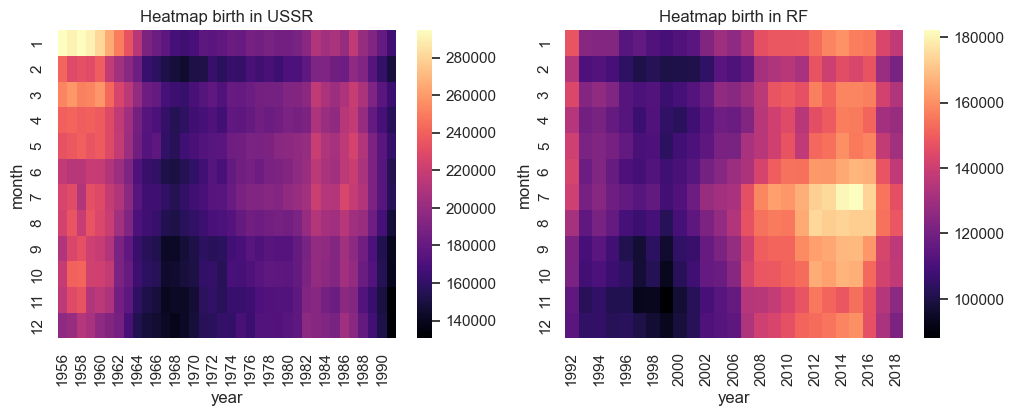

In [168]:
fig, ax = plt.subplots(1,2, figsize = (12,4))

sns.heatmap(birth_USSR_pivot_table, linecolor='white', linewidths=0, cmap = 'magma', ax=ax[0])
ax[0].set_title('Heatmap birth in USSR')

sns.heatmap(birth_RF_pivot_table, linecolor='white', linewidths=0, cmap = 'magma', ax=ax[1])
ax[1].set_title('Heatmap birth in RF');

## Сравнение рождаемости по месяцам/годам и стране

### СССР 
После 1962 года наблюдается снижение рождаемости (черная и темно-фиолетовая область на левом графике), в 1968 г заметен самый низкий уровень рождаемости во всех месяцах. Далее идет незначительное повышение, и в 1990-1991 г область снова становится черной во всех месяцах (минимальный уровень рождаемости)

### РФ
С 1992 по 2006 г. находится на минимальном уровне, минимум рождаемости виден вконце 1998-1999 года
с 2006 по 2018 г. период повышенной рождаемости
с 2018 г. график снова начинает темнеть (снижение рождаемости)


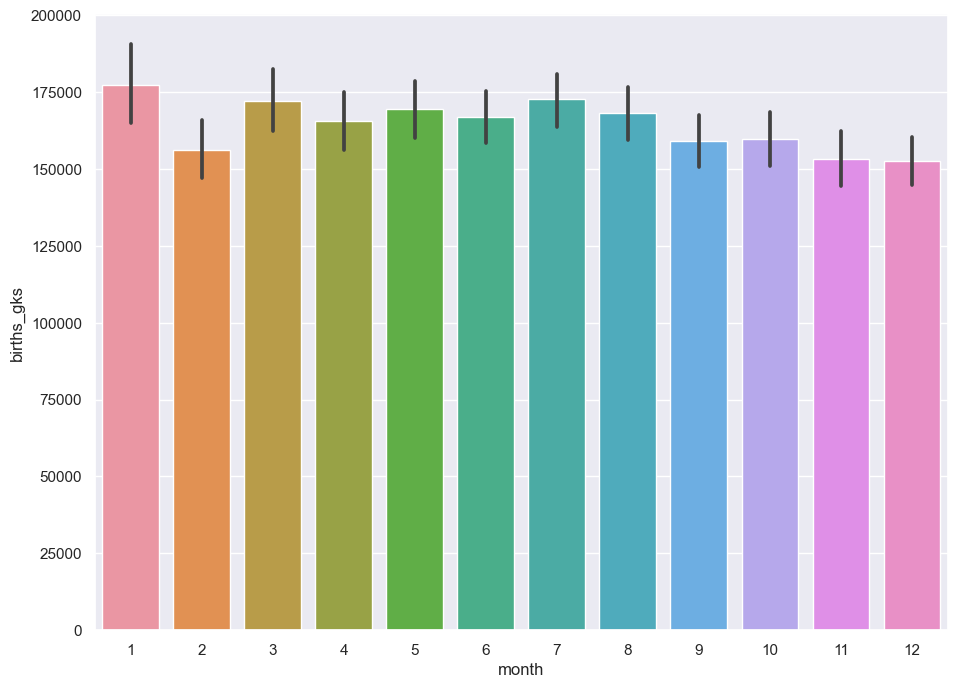

In [47]:
sns.barplot(x='month', y='births_gks', data = df);